<a href="https://colab.research.google.com/github/earthwittawat2548/Crossec/blob/master/CrossecML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q fastbook 

     |████████████████████████████████| 719 kB 15.4 MB/s 
     |████████████████████████████████| 362 kB 43.9 MB/s 
     |████████████████████████████████| 4.4 MB 59.9 MB/s 
     |████████████████████████████████| 1.2 MB 49.7 MB/s 
     |████████████████████████████████| 1.1 MB 65.7 MB/s 
     |████████████████████████████████| 140 kB 62.5 MB/s 
     |████████████████████████████████| 212 kB 54.4 MB/s 
     |████████████████████████████████| 101 kB 6.1 MB/s 
     |████████████████████████████████| 596 kB 35.7 MB/s 
     |████████████████████████████████| 127 kB 57.1 MB/s 
     |████████████████████████████████| 271 kB 59.9 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 144 kB 72.9 MB/s 
     |████████████████████████████████| 6.6 MB 59.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10

In [2]:
from fastai.vision.all import *

from fastcore.foundation import L

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import fit_one_cycle

from fastai.data.core import Datasets, show_at
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import IntToFloatTensor, Normalize, ToTensor, IndexSplitter, get_image_files, parent_label, Categorize

from fastai.metrics import accuracy

from fastai.vision.augment import aug_transforms, RandomResizedCrop
from fastai.vision.core import PILImage, imagenet_stats
from fastai.vision.learner import cnn_learner

import random

from sklearn.model_selection import StratifiedKFold

from torchvision.models.resnet import resnet34

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/content/CrossecDataset/dataset/Dataset_pretrained.zip -d data

In [7]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import splitfolders

splitfolders.ratio("/content/data/data", output="/content/data/dataset",
    seed=1337, ratio=(.8, .2 ), group_prefix=None, move=False) 

Copying files: 1451 files [00:00, 3443.87 files/s]


In [19]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(valid_name='val'),
    get_y=parent_label, 
    batch_tfms=aug_transforms(size=224,do_flip=True,flip_vert=True,min_zoom=1,max_zoom=1.1,max_rotate=10,max_lighting=0.75)
    )
dls = dblock.dataloaders('/content/data/dataset/', bs=32)

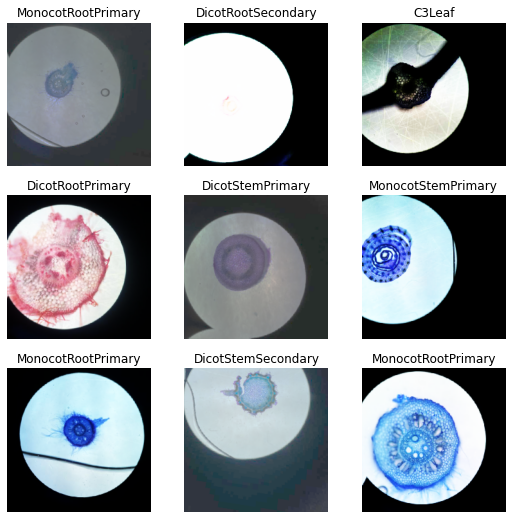

In [20]:
dls.train.show_batch(max_n=9,nrows=3)

In [21]:
learn = cnn_learner(dls, resnet34, metrics=accuracy).to_fp16()

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.0005754399462603033)

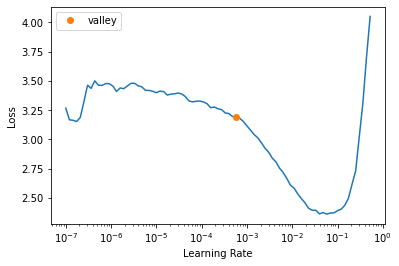

In [22]:
learn.lr_find()

In [23]:
learn.fine_tune(epochs=10, freeze_epochs=1, base_lr=0.0005754399462603033)

epoch,train_loss,valid_loss,accuracy,time
0,2.611121,0.819888,0.727891,00:09


epoch,train_loss,valid_loss,accuracy,time
0,1.581848,0.601646,0.802721,00:10
1,1.354827,0.365449,0.877551,00:09
2,1.008627,0.213148,0.911565,00:09
3,0.769668,0.132488,0.959184,00:09
4,0.569110,0.120304,0.952381,00:09
5,0.420733,0.083780,0.965986,00:09
6,0.352249,0.071329,0.972789,00:09
7,0.305747,0.072710,0.972789,00:09
8,0.290426,0.064647,0.979592,00:09
9,0.270043,0.067497,0.979592,00:09


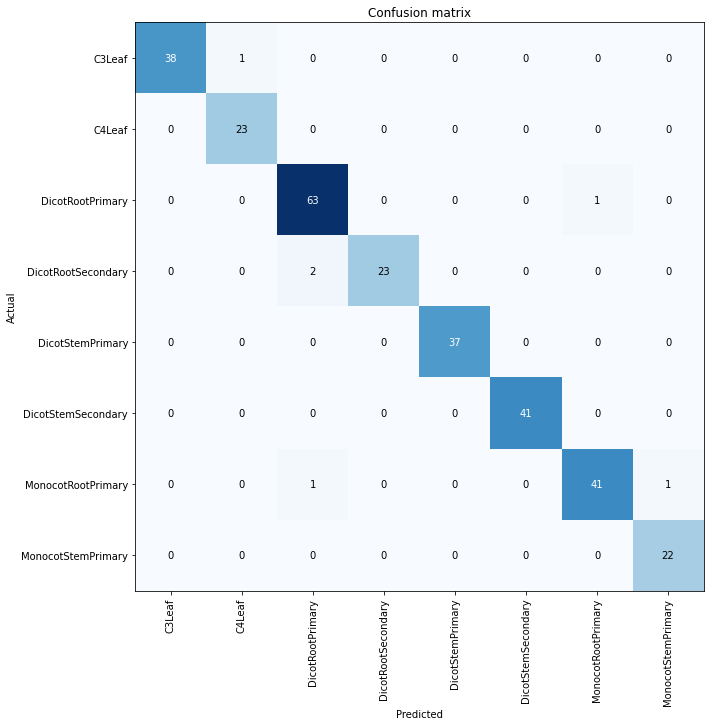

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

In [25]:
interp.print_classification_report()

                    precision    recall  f1-score   support

            C3Leaf       1.00      0.97      0.99        39
            C4Leaf       0.96      1.00      0.98        23
  DicotRootPrimary       0.95      0.98      0.97        64
DicotRootSecondary       1.00      0.92      0.96        25
  DicotStemPrimary       1.00      1.00      1.00        37
DicotStemSecondary       1.00      1.00      1.00        41
MonocotRootPrimary       0.98      0.95      0.96        43
MonocotStemPrimary       0.96      1.00      0.98        22

          accuracy                           0.98       294
         macro avg       0.98      0.98      0.98       294
      weighted avg       0.98      0.98      0.98       294



In [26]:
item_tfms = [ToTensor(), RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))]
batch_tfms = [IntToFloatTensor(), *aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

In [27]:
train_imgs = get_image_files('/content/data/dataset/train')
tst_imgs = get_image_files('/content/data/dataset/val')

In [28]:
random.shuffle(train_imgs)

In [29]:
len(train_imgs)

1157

In [30]:
train_imgs

(#1157) [Path('/content/data/dataset/train/DicotStemPrimary/IMG_1280.jpg'),Path('/content/data/dataset/train/DicotRootPrimary/IMG_9169.jpg'),Path('/content/data/dataset/train/DicotStemSecondary/IMG_9873.JPEG'),Path('/content/data/dataset/train/DicotRootSecondary/IMG_1921.jpg'),Path('/content/data/dataset/train/DicotRootPrimary/IMG_1563.jpg'),Path('/content/data/dataset/train/DicotStemPrimary/IMG_1276.jpg'),Path('/content/data/dataset/train/DicotRootPrimary/IMG_1592.jpg'),Path('/content/data/dataset/train/DicotRootSecondary/IMG_1958.jpg'),Path('/content/data/dataset/train/DicotStemSecondary/IMG_1331.jpg'),Path('/content/data/dataset/train/DicotStemSecondary/IMG_9800.JPEG')...]

In [31]:
start_val = len(train_imgs) - int(len(train_imgs)*.2)
idxs = list(range(start_val, len(train_imgs)))
splitter = IndexSplitter(idxs)
splits = splitter(train_imgs)

In [32]:
split_list = [splits[0], splits[1]]

In [33]:
split_list.append(L(range(len(train_imgs), len(train_imgs)+len(tst_imgs))))

In [34]:
split_list

[(#926) [0,1,2,3,4,5,6,7,8,9...],
 (#231) [926,927,928,929,930,931,932,933,934,935...],
 (#294) [1157,1158,1159,1160,1161,1162,1163,1164,1165,1166...]]

In [35]:
dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [parent_label, Categorize]],
                splits = split_list)

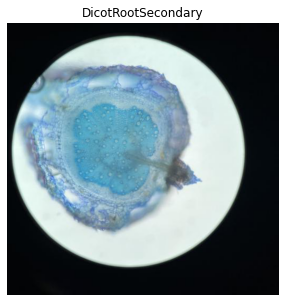

In [36]:
show_at(dsrc.train, 3)

In [37]:
dsrc.n_subsets

3

In [38]:
dls = dsrc.dataloaders(bs=bs, after_item=item_tfms, after_batch=batch_tfms)

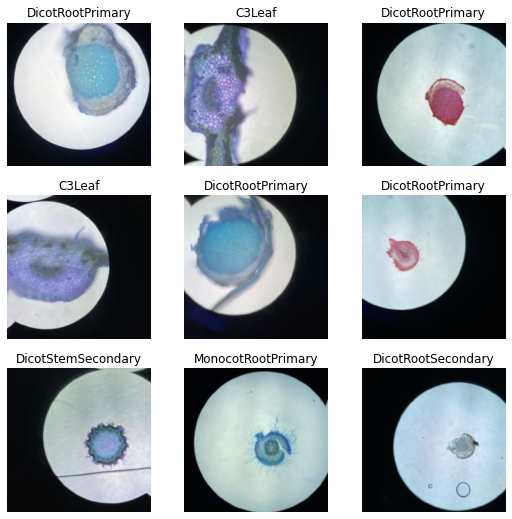

In [42]:
dls.show_batch()

In [40]:
dls.n_subsets

3

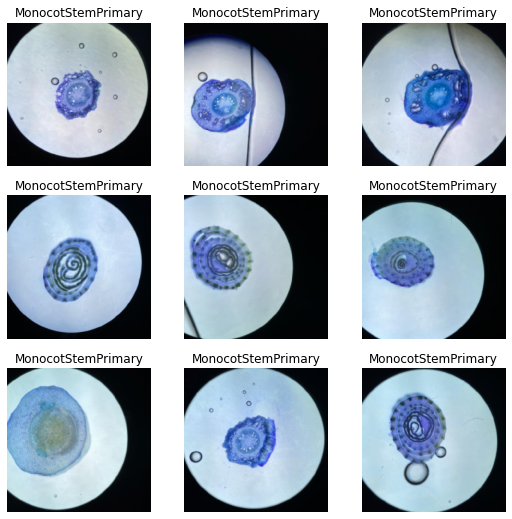

In [41]:
dls[2].show_batch()

In [43]:
train_labels = L(dsrc.items).map(dsrc.tfms[1])

In [54]:
kf = StratifiedKFold(n_splits=10, shuffle=True)

In [55]:
n_splits = 10

In [56]:
random.shuffle(train_imgs)

In [ ]:
val_pct = []
tst_preds = []
skf = StratifiedKFold(n_splits=10, shuffle=True)
for _, val_idx in kf.split(np.array(train_imgs+tst_imgs), train_labels):
  splits = IndexSplitter(val_idx)
  split = splits(train_imgs)
  split_list = [split[0], split[1]]
  split_list.append(L(range(len(train_imgs), len(train_imgs)+len(tst_imgs))))
  dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [parent_label, Categorize]],
                  splits=split_list)
  dls = dsrc.dataloaders(bs=bs, after_item=item_tfms, after_batch=batch_tfms)
  learn = cnn_learner(dls, resnet34, metrics=accuracy)
  learn.fit_one_cycle(10)
  val_pct.append(learn.validate()[1])
  a,b = learn.get_preds(ds_idx=2)
  tst_preds.append(a)

In [59]:
tst_preds_copy = tst_preds.copy()
accuracy(tst_preds_copy[0], b)

TensorBase(0.9490)

In [63]:
for i in tst_preds_copy:
  print(accuracy(i, b))

TensorBase(0.9490)
TensorBase(0.9524)
TensorBase(0.9422)
TensorBase(0.9558)
TensorBase(0.9626)
TensorBase(0.9626)
TensorBase(0.9524)
TensorBase(0.9694)
TensorBase(0.9354)
TensorBase(0.9490)


In [64]:
hat

TensorBase([[8.0851e-04, 6.5933e-04, 1.8558e-04,  ..., 2.7421e-04, 6.7418e-02,
         8.7184e-01],
        [3.0929e-06, 1.2638e-05, 2.2097e-06,  ..., 2.8004e-05, 7.3959e-05,
         9.9967e-01],
        [2.2348e-03, 1.1921e-03, 1.8103e-04,  ..., 9.0628e-04, 8.7336e-01,
         1.1818e-01],
        ...,
        [9.6192e-03, 8.7052e-03, 5.8084e-01,  ..., 7.6180e-03, 1.3077e-01,
         2.5236e-02],
        [2.4452e-05, 8.1849e-04, 9.6165e-01,  ..., 2.7014e-04, 3.0099e-02,
         4.8551e-03],
        [3.0949e-04, 9.9638e-05, 9.8096e-01,  ..., 8.0922e-05, 1.1769e-02,
         2.2811e-03]])

In [50]:
hat = tst_preds[0]
for pred in tst_preds[1:]:
  hat += pred

In [51]:
hat /= len(tst_preds)

In [52]:
accuracy(hat, b)

TensorBase(0.9694)

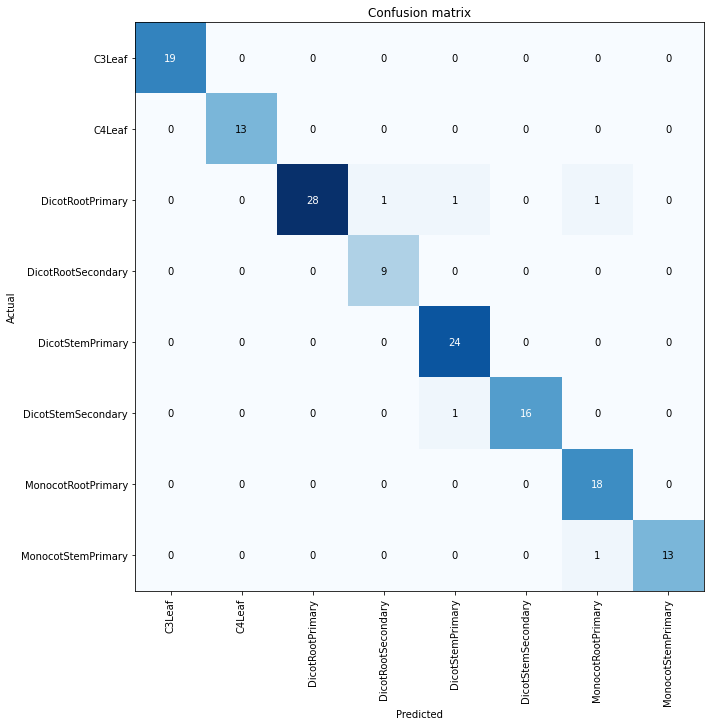

In [65]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

In [66]:
interp.print_classification_report()

                    precision    recall  f1-score   support

            C3Leaf       1.00      1.00      1.00        19
            C4Leaf       1.00      1.00      1.00        13
  DicotRootPrimary       1.00      0.90      0.95        31
DicotRootSecondary       0.90      1.00      0.95         9
  DicotStemPrimary       0.92      1.00      0.96        24
DicotStemSecondary       1.00      0.94      0.97        17
MonocotRootPrimary       0.90      1.00      0.95        18
MonocotStemPrimary       1.00      0.93      0.96        14

          accuracy                           0.97       145
         macro avg       0.97      0.97      0.97       145
      weighted avg       0.97      0.97      0.97       145

